### 分析のコード解説

1. データの統合と整理


* 足立区と港区の別々のデータベース（adachi.db, minato.db）から給与情報を読み込む
* メモリ上の一時データベースに統合し、地域情報を付加
* データの整合性を保ちながら比較分析が可能な形に整形


2. 分析機能


* SQLクエリを使用して区ごとの詳細な統計情報を算出
* 求人件数、平均時給、最低/最高時給を計算して比較
* 両区の時給差を数値化し、地域間格差を定量的に評価


3. データの可視化

* 箱ひげ図により時給の分布範囲や外れ値を表示
* 棒グラフで平均時給を視覚的に比較
* グラフに実際の数値を表示し、直感的な理解を促進
* matplotlib と seaborn ライブラリを使用した効果的な可視化


4. 分析結果の出力


* 各区の統計情報を詳細に表示して比較
* 平均時給の差から仮説（港区の時給が高い）を検証
* 分析結果を定量的なデータとして提示

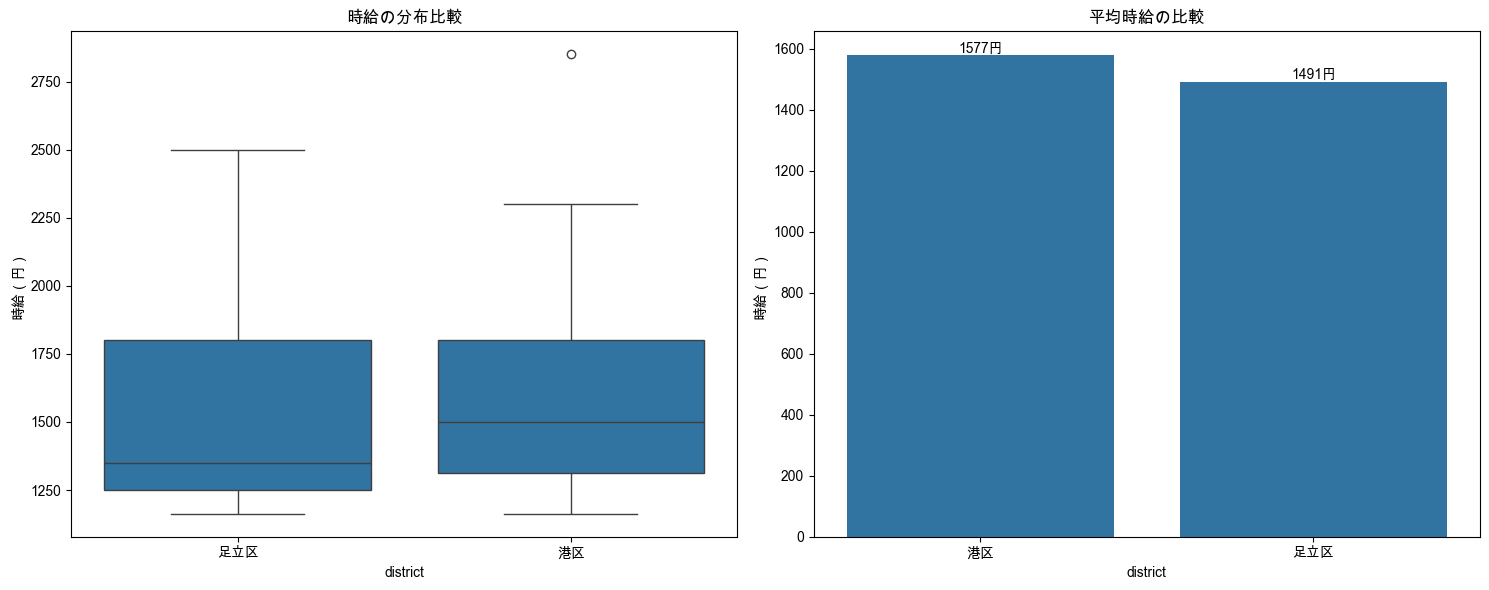


=== 詳細な統計情報 ===

港区:
- 求人数: 443件
- 平均時給: 1577.2円
- 最低時給: 1163円
- 最高時給: 2850円

足立区:
- 求人数: 422件
- 平均時給: 1491.1円
- 最低時給: 1163円
- 最高時給: 2500円

港区と足立区の平均時給差: 86.1円

=== 仮説の検証 ===
仮説が支持されました：港区の平均時給が足立区より高いことが確認されました。


In [2]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

class WageAnalyzer:
    def __init__(self):
        # 両方のデータを統合して分析するための一時的なデータベース接続
        self.conn = sqlite3.connect(':memory:')
        self.load_data()

    def load_data(self):
        """両方のDBからデータを読み込んで統合"""
        # 足立区のデータ読み込み
        adachi_conn = sqlite3.connect('adachi.db')
        adachi_df = pd.read_sql('SELECT * FROM jobs', adachi_conn)
        adachi_df['district'] = '足立区'
        adachi_conn.close()

        # 港区のデータ読み込み
        minato_conn = sqlite3.connect('minato.db')
        minato_df = pd.read_sql('SELECT * FROM jobs', minato_conn)
        minato_df['district'] = '港区'
        minato_conn.close()

        # データの統合とメモリ上のDBへの保存
        combined_df = pd.concat([adachi_df, minato_df])
        combined_df.to_sql('jobs', self.conn, if_exists='replace', index=False)

    def analyze_wages(self):
        """賃金分析の実行"""
        # 区ごとの基本統計量を取得
        query = """
        SELECT
            district,
            COUNT(*) as count,
            AVG(wage_info) as avg_wage,
            MIN(wage_info) as min_wage,
            MAX(wage_info) as max_wage
        FROM jobs
        GROUP BY district
        """
        stats = pd.read_sql_query(query, self.conn)

        # 可視化
        plt.rcParams['font.family'] = 'Arial Unicode MS'
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

        # 箱ひげ図
        data = pd.read_sql('SELECT * FROM jobs', self.conn)
        sns.boxplot(data=data, x='district', y='wage_info', ax=ax1)
        ax1.set_title('時給の分布比較')
        ax1.set_ylabel('時給（円）')

        # 平均時給の棒グラフ
        sns.barplot(data=stats, x='district', y='avg_wage', ax=ax2)
        ax2.set_title('平均時給の比較')
        ax2.set_ylabel('時給（円）')

        for i, v in enumerate(stats['avg_wage']):
            ax2.text(i, v, f'{v:.0f}円', ha='center', va='bottom')

        plt.tight_layout()
        plt.show()

        # 統計情報の出力
        print("\n=== 詳細な統計情報 ===")
        for _, row in stats.iterrows():
            print(f"\n{row['district']}:")
            print(f"- 求人数: {row['count']}件")
            print(f"- 平均時給: {row['avg_wage']:.1f}円")
            print(f"- 最低時給: {row['min_wage']}円")
            print(f"- 最高時給: {row['max_wage']}円")

        # 時給差の計算と仮説検証
        wage_diff = stats[stats['district']=='港区']['avg_wage'].values[0] - \
                   stats[stats['district']=='足立区']['avg_wage'].values[0]
        print(f"\n港区と足立区の平均時給差: {wage_diff:.1f}円")

        # 仮説の検証結果
        print("\n=== 仮説の検証 ===")
        if wage_diff > 0:
            print("仮説が支持されました：港区の平均時給が足立区より高いことが確認されました。")
        else:
            print("仮説は支持されませんでした：予想に反する結果となりました。")

if __name__ == "__main__":
    analyzer = WageAnalyzer()
    analyzer.analyze_wages()